In [4]:
import os
import json
import requests
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import seaborn as sns


%matplotlib inline

In [5]:
load_dotenv()

True

In [6]:
csvpath = Path('pandemic_stock_picks.csv')
ticker_data = pd.read_csv(csvpath, infer_datetime_format=True, parse_dates=True)
ticker_data.sort_index()
ticker_data.head()

,Unnamed: 0,AAPL,AAPL.1,AAPL.2,AAPL.3,AAPL.4,AMD,AMD.1,AMD.2,AMD.3,...,WING,WING.1,WING.2,WING.3,WING.4,ZM,ZM.1,ZM.2,ZM.3,ZM.4
0,NaN,open,high,low,close,volume,open,high,low,close,...,open,high,low,close,volume,open,high,low,close,volume
1,time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-03-06 00:00:00-05:00,174.67,175.49,173.94,174.51,17535168,23.47,23.53,22.4,22.41,...,66.66,67.0,65.84,65.87,393804,NaN,NaN,NaN,NaN,NaN
3,2019-03-07 00:00:00-05:00,174.02,174.44,172.02,172.47,20110131,22.33,22.4101,21.73,22.07,...,65.69,66.0386,64.8,65.39,280014,NaN,NaN,NaN,NaN,NaN
4,2019-03-08 00:00:00-05:00,170.32,173.07,169.5,172.92,19475688,21.35,22.085,21.035,22.0103,...,65.27,67.16,64.7244,66.65,632366,NaN,NaN,NaN,NaN,NaN


In [7]:
month_close_data = ticker_data[['AAPL.3','FB.3','AMZN.3','NFLX.3','GOOG.3','SHOP.3','NVDA.3', 'AMD.3','PEP.3','MKC.3', 'DPZ.3','WING.3','ATVI.3','COST.3','CPB.3','ETSY.3','OKTA.3','PLD.3','TTWO.3','ZM.3']].drop([0,1])
month_close_data.apply(pd.to_numeric, axis=0).head()

,AAPL.3,FB.3,AMZN.3,NFLX.3,GOOG.3,SHOP.3,NVDA.3,AMD.3,PEP.3,MKC.3,DPZ.3,WING.3,ATVI.3,COST.3,CPB.3,ETSY.3,OKTA.3,PLD.3,TTWO.3,ZM.3
2,174.51,172.51,1669.16,359.50,1157.96,187.300,152.04,22.4100,116.63,136.47,248.65,65.87,42.56,219.19,36.14,70.04,79.9800,70.17,87.22,NaN
3,172.47,169.14,1626.28,352.62,1143.53,186.970,149.25,22.0700,116.08,135.66,247.83,65.39,41.42,216.79,35.92,67.23,81.2200,69.52,88.41,NaN
4,172.92,169.60,1622.11,349.58,1142.74,189.730,150.67,22.0103,115.22,137.05,250.53,66.65,42.04,227.82,36.01,67.80,78.4250,69.94,87.04,NaN
5,178.98,171.98,1670.32,358.86,1175.81,200.300,161.13,22.9500,116.56,139.05,246.98,66.81,42.92,229.63,35.90,70.64,80.9101,70.99,89.80,NaN
6,180.94,171.94,1672.42,356.28,1192.72,202.545,162.51,23.4800,116.61,138.41,240.36,66.87,42.63,232.98,35.06,71.14,80.6500,71.64,89.86,NaN


In [8]:
stock_list = month_close_data.astype(str).astype(float).loc[255:276]
stock_list.columns = ['AAPL','FB','AMZN','NFLX','GOOG','SHOP','NVDA', 'AMD','PEP','MKC', 'DPZ','WING','ATVI','COST','CPB','ETSY','OKTA','PLD','TTWO','ZM']
stock_list.head()

,AAPL,FB,AMZN,NFLX,GOOG,SHOP,NVDA,AMD,PEP,MKC,DPZ,WING,ATVI,COST,CPB,ETSY,OKTA,PLD,TTWO,ZM
255,288.98,181.11,1901.14,368.90,1298.41,472.0877,266.070,48.600,137.27,150.54,336.47,79.28,59.960,311.340,51.750,60.61,125.99,85.83,117.71,114.3300
256,266.09,168.60,1800.01,346.03,1214.51,417.6100,245.010,43.260,130.15,143.87,336.26,74.76,57.165,300.945,50.190,58.50,114.86,77.76,113.83,113.7500
257,285.69,178.19,1894.00,364.27,1281.01,450.1700,261.080,45.380,134.23,151.49,344.05,76.17,60.720,309.670,51.250,57.97,119.21,80.86,118.75,108.4858
258,275.30,170.22,1819.63,349.59,1215.10,422.2300,246.160,45.690,129.66,146.61,332.66,71.57,59.330,297.270,50.475,50.21,114.77,73.72,118.90,110.2600
259,248.00,154.46,1676.21,312.63,1113.84,377.5200,216.035,39.005,115.34,131.17,315.61,68.26,54.560,279.635,47.660,44.04,106.08,70.17,108.35,109.4700


In [9]:
stock_list['Date'] = pd.date_range(start='03/06/2020', periods=len(stock_list), freq='B')
stock_list_final = stock_list[['Date','AAPL','FB','AMZN','NFLX','GOOG','SHOP','NVDA', 'AMD','PEP','MKC', 'DPZ','WING','ATVI','COST','CPB','ETSY','OKTA','PLD','TTWO','ZM']]
stock_list_final.reset_index()
stocks = stock_list_final.set_index('Date')
stocks.head()

,AAPL,FB,AMZN,NFLX,GOOG,SHOP,NVDA,AMD,PEP,MKC,DPZ,WING,ATVI,COST,CPB,ETSY,OKTA,PLD,TTWO,ZM
Date,,,,,,,,,,,,,,,,,,,,
2020-03-06,288.98,181.11,1901.14,368.90,1298.41,472.0877,266.070,48.600,137.27,150.54,336.47,79.28,59.960,311.340,51.750,60.61,125.99,85.83,117.71,114.3300
2020-03-09,266.09,168.60,1800.01,346.03,1214.51,417.6100,245.010,43.260,130.15,143.87,336.26,74.76,57.165,300.945,50.190,58.50,114.86,77.76,113.83,113.7500
2020-03-10,285.69,178.19,1894.00,364.27,1281.01,450.1700,261.080,45.380,134.23,151.49,344.05,76.17,60.720,309.670,51.250,57.97,119.21,80.86,118.75,108.4858
2020-03-11,275.30,170.22,1819.63,349.59,1215.10,422.2300,246.160,45.690,129.66,146.61,332.66,71.57,59.330,297.270,50.475,50.21,114.77,73.72,118.90,110.2600
2020-03-12,248.00,154.46,1676.21,312.63,1113.84,377.5200,216.035,39.005,115.34,131.17,315.61,68.26,54.560,279.635,47.660,44.04,106.08,70.17,108.35,109.4700


In [10]:
daily_returns = stocks.pct_change()
daily_returns.head()

,AAPL,FB,AMZN,NFLX,GOOG,SHOP,NVDA,AMD,PEP,MKC,DPZ,WING,ATVI,COST,CPB,ETSY,OKTA,PLD,TTWO,ZM
Date,,,,,,,,,,,,,,,,,,,,
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,-0.079210,-0.069074,-0.053194,-0.061995,-0.064617,-0.115397,-0.079152,-0.109877,-0.051869,-0.044307,-0.000624,-0.057013,-0.046614,-0.033388,-0.030145,-0.034813,-0.088340,-0.094023,-0.032962,-0.005073
2020-03-10,0.073659,0.056880,0.052216,0.052712,0.054755,0.077967,0.065589,0.049006,0.031348,0.052964,0.023167,0.018860,0.062188,0.028992,0.021120,-0.009060,0.037872,0.039866,0.043222,-0.046279
2020-03-11,-0.036368,-0.044728,-0.039266,-0.040300,-0.051452,-0.062065,-0.057147,0.006831,-0.034046,-0.032213,-0.033106,-0.060391,-0.022892,-0.040043,-0.015122,-0.133862,-0.037245,-0.088301,0.001263,0.016354
2020-03-12,-0.099165,-0.092586,-0.078818,-0.105724,-0.083335,-0.105890,-0.122380,-0.146312,-0.110443,-0.105313,-0.051254,-0.046248,-0.080398,-0.059323,-0.055770,-0.122884,-0.075717,-0.048155,-0.088730,-0.007165


<AxesSubplot:xlabel='Date'>

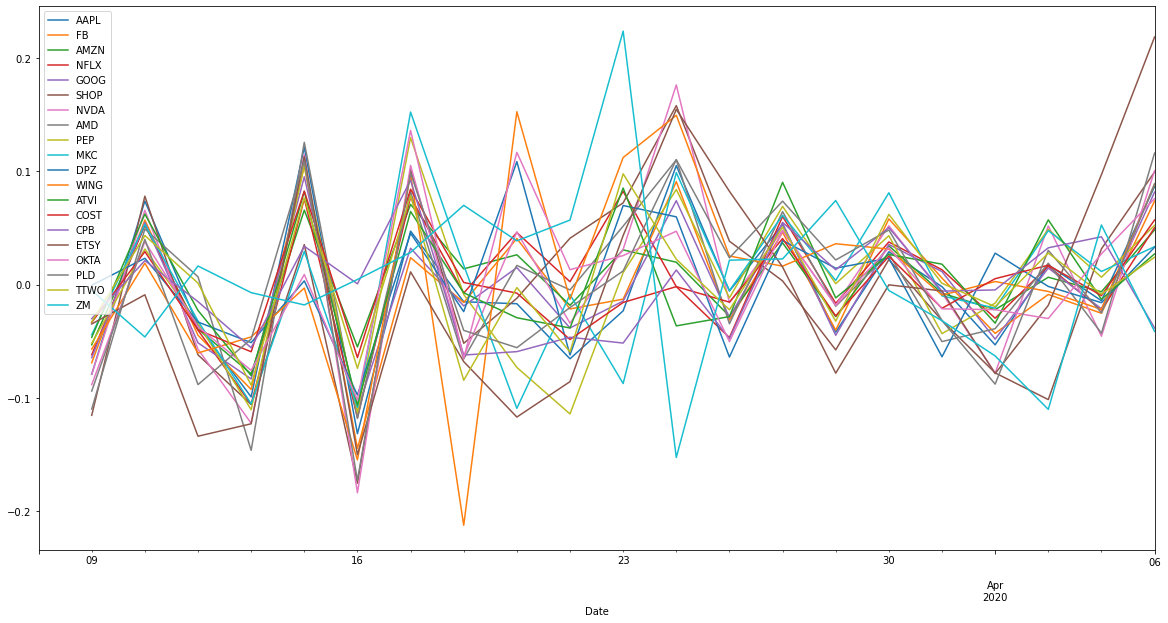

In [11]:
daily_returns.plot(figsize= (20,10))

In [12]:
cum_returns = (1+daily_returns).cumprod()
cum_returns.head()

,AAPL,FB,AMZN,NFLX,GOOG,SHOP,NVDA,AMD,PEP,MKC,DPZ,WING,ATVI,COST,CPB,ETSY,OKTA,PLD,TTWO,ZM
Date,,,,,,,,,,,,,,,,,,,,
2020-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-09,0.920790,0.930926,0.946806,0.938005,0.935383,0.884603,0.920848,0.890123,0.948131,0.955693,0.999376,0.942987,0.953386,0.966612,0.969855,0.965187,0.911660,0.905977,0.967038,0.994927
2020-03-10,0.988615,0.983877,0.996244,0.987449,0.986599,0.953573,0.981246,0.933745,0.977854,1.006311,1.022528,0.960772,1.012675,0.994636,0.990338,0.956443,0.946186,0.942095,1.008835,0.948883
2020-03-11,0.952661,0.939871,0.957126,0.947655,0.935837,0.894389,0.925170,0.940123,0.944562,0.973894,0.988677,0.902750,0.989493,0.954808,0.975362,0.828411,0.910945,0.858907,1.010110,0.964401
2020-03-12,0.858191,0.852852,0.881687,0.847465,0.857849,0.799682,0.811948,0.802572,0.840242,0.871330,0.938003,0.860999,0.909940,0.898166,0.920966,0.726613,0.841972,0.817546,0.920483,0.957491


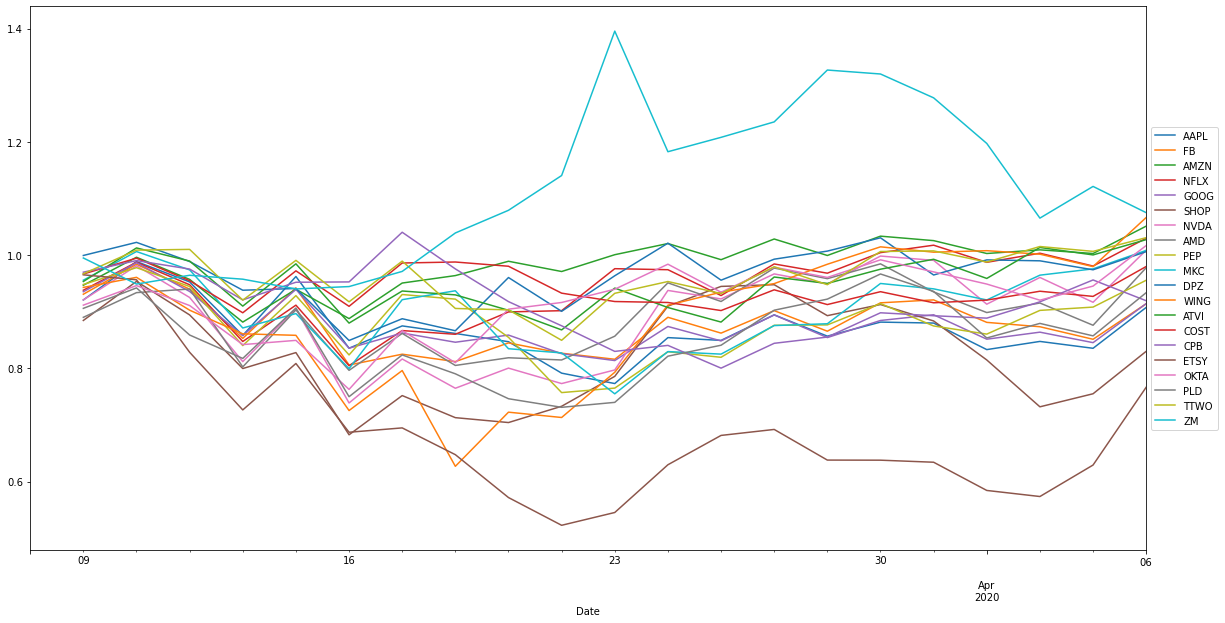

In [13]:
cum_returns.plot(figsize=(20,10)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));


In [14]:
standard_deviation = cum_returns.std()
standard_deviation

AAPL    0.052699
FB      0.049454
AMZN    0.044476
NFLX    0.061645
GOOG    0.043692
SHOP    0.087819
NVDA    0.085263
AMD     0.061826
PEP     0.060639
MKC     0.071015
DPZ     0.051368
WING    0.120914
ATVI    0.047172
COST    0.031308
CPB     0.060751
ETSY    0.120870
OKTA    0.063290
PLD     0.072358
TTWO    0.047693
ZM      0.142844
dtype: float64

<AxesSubplot:>

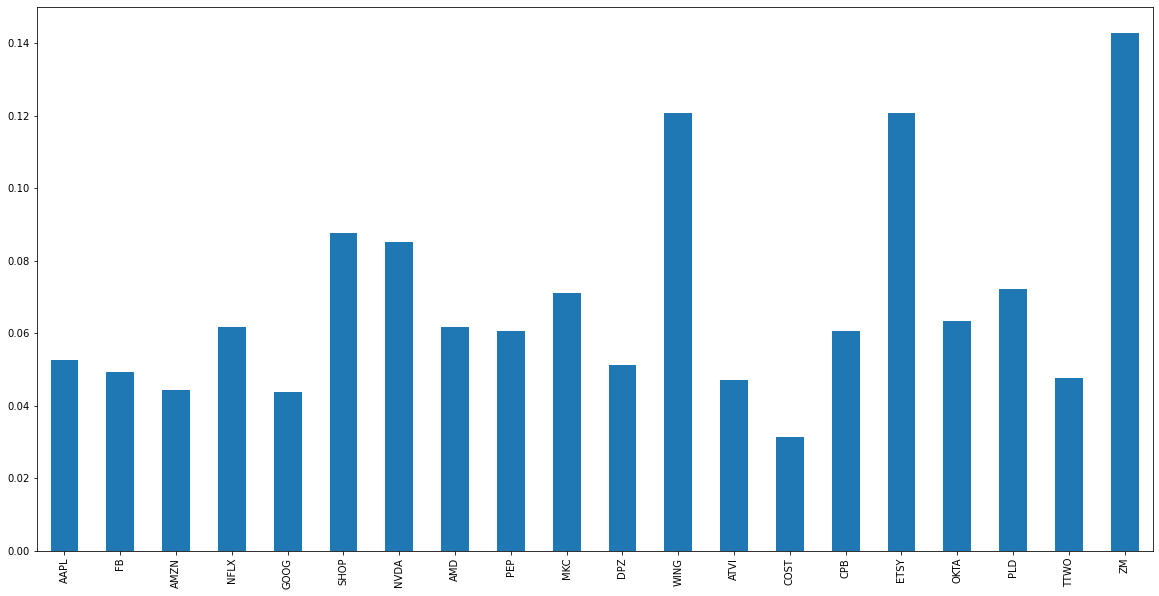

In [15]:
standard_deviation.plot(kind='bar', figsize=(20,10))


In [18]:
sp500_file = Path('Resources/snp_data_5Y.csv')
sp500_df = pd.read_csv(sp500_file, index_col="Date", infer_datetime_format=True, parse_dates=True)
sp500 = sp500_df.drop(columns=['Volume','Open','High','Low'])
sp500.columns = ['S&P 500']
sp500.head()

,S&P 500
Date,
2021-05-28,4204.11
2021-05-27,4200.88
2021-05-26,4195.99
2021-05-25,4188.13
2021-05-24,4197.05


In [19]:
combined_df = pd.concat([stocks, sp500], axis='columns', join='inner')
combined_df.head()

,AAPL,FB,AMZN,NFLX,GOOG,SHOP,NVDA,AMD,PEP,MKC,...,WING,ATVI,COST,CPB,ETSY,OKTA,PLD,TTWO,ZM,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-06,288.98,181.11,1901.14,368.90,1298.41,472.0877,266.070,48.600,137.27,150.54,...,79.28,59.960,311.340,51.750,60.61,125.99,85.83,117.71,114.3300,2972.37
2020-03-09,266.09,168.60,1800.01,346.03,1214.51,417.6100,245.010,43.260,130.15,143.87,...,74.76,57.165,300.945,50.190,58.50,114.86,77.76,113.83,113.7500,2746.56
2020-03-10,285.69,178.19,1894.00,364.27,1281.01,450.1700,261.080,45.380,134.23,151.49,...,76.17,60.720,309.670,51.250,57.97,119.21,80.86,118.75,108.4858,2882.23
2020-03-11,275.30,170.22,1819.63,349.59,1215.10,422.2300,246.160,45.690,129.66,146.61,...,71.57,59.330,297.270,50.475,50.21,114.77,73.72,118.90,110.2600,2741.38
2020-03-12,248.00,154.46,1676.21,312.63,1113.84,377.5200,216.035,39.005,115.34,131.17,...,68.26,54.560,279.635,47.660,44.04,106.08,70.17,108.35,109.4700,2480.64


In [20]:
price_correlation = combined_df.corr()
price_correlation.head()

,AAPL,FB,AMZN,NFLX,GOOG,SHOP,NVDA,AMD,PEP,MKC,...,WING,ATVI,COST,CPB,ETSY,OKTA,PLD,TTWO,ZM,S&P 500
AAPL,1.000000,0.879979,0.016223,0.233479,0.969647,0.613038,0.563633,0.544225,0.856288,0.683700,...,0.375935,0.585282,0.647546,0.559307,0.895431,0.173914,0.734338,0.581365,-0.527899,0.959794
FB,0.879979,1.000000,0.310214,0.587005,0.943335,0.783558,0.798552,0.748390,0.699697,0.653516,...,0.652898,0.668753,0.422578,0.250569,0.762223,0.524529,0.838213,0.661012,-0.202736,0.929164
AMZN,0.016223,0.310214,1.000000,0.879557,0.122986,0.408000,0.680885,0.703009,0.134616,0.280976,...,0.577784,0.476228,0.084450,-0.394169,-0.189241,0.878949,0.440702,0.445675,0.632519,0.144905
NFLX,0.233479,0.587005,0.879557,1.000000,0.370591,0.572548,0.860706,0.818690,0.296895,0.467302,...,0.821251,0.715821,0.043673,-0.272456,0.079328,0.915676,0.661473,0.671009,0.497970,0.404446
GOOG,0.969647,0.943335,0.122986,0.370591,1.000000,0.661961,0.627576,0.595237,0.808299,0.678376,...,0.451537,0.620737,0.631269,0.489431,0.893747,0.315708,0.750579,0.590641,-0.447035,0.966030


<AxesSubplot:>

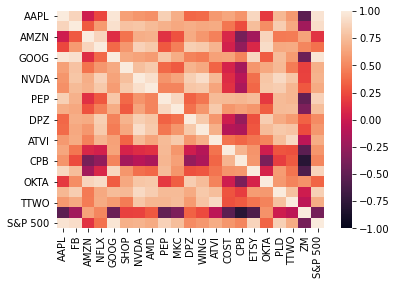

In [21]:
sns.heatmap(price_correlation, vmin=-1,vmax=1)

<AxesSubplot:xlabel='Date'>

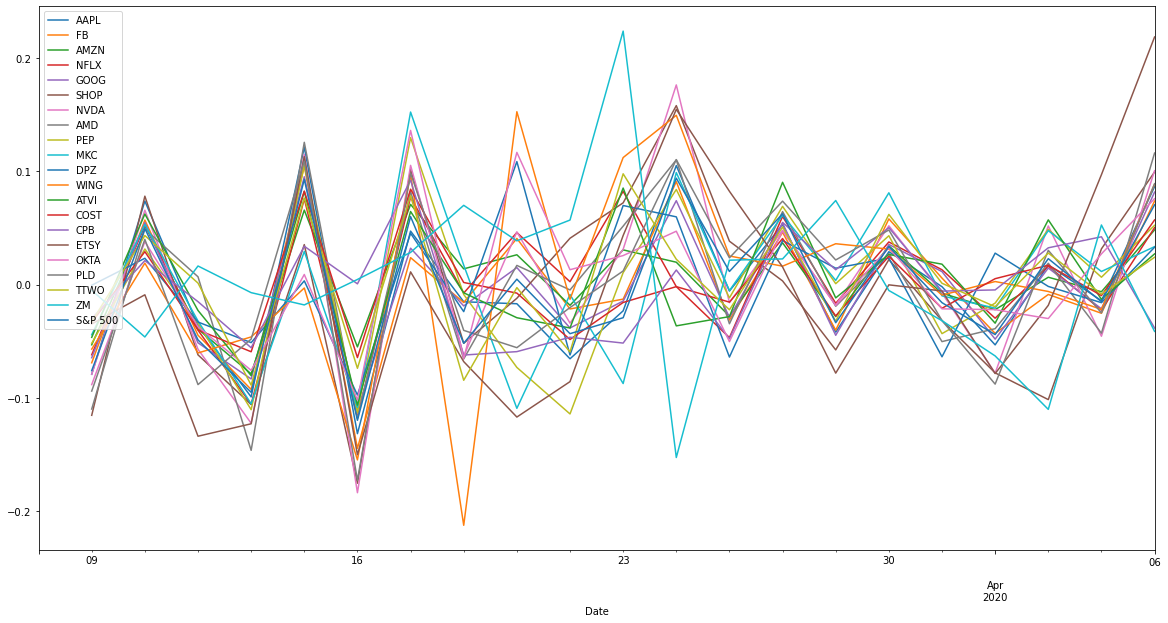

In [22]:
combined_daily_returns = combined_df.pct_change()
combined_daily_returns.plot(figsize=(20,10))

In [23]:
correlation = combined_daily_returns.corr()
correlation.head()

,AAPL,FB,AMZN,NFLX,GOOG,SHOP,NVDA,AMD,PEP,MKC,...,WING,ATVI,COST,CPB,ETSY,OKTA,PLD,TTWO,ZM,S&P 500
AAPL,1.000000,0.944261,0.852511,0.756911,0.974543,0.759049,0.924885,0.885816,0.866597,0.740155,...,0.506555,0.714584,0.842148,0.453653,0.765186,0.630575,0.888136,0.722899,-0.353235,0.971438
FB,0.944261,1.000000,0.867097,0.826935,0.976768,0.775461,0.932016,0.880541,0.739777,0.639516,...,0.597125,0.674659,0.780142,0.334958,0.668892,0.729854,0.837081,0.701737,-0.267957,0.935558
AMZN,0.852511,0.867097,1.000000,0.933087,0.889462,0.722297,0.841486,0.863763,0.797040,0.642939,...,0.495861,0.819357,0.888530,0.451352,0.569965,0.792185,0.764327,0.794623,-0.011562,0.845286
NFLX,0.756911,0.826935,0.933087,1.000000,0.823466,0.685688,0.815932,0.841334,0.698423,0.522230,...,0.585879,0.891306,0.781830,0.348095,0.483996,0.793606,0.729731,0.835386,0.153723,0.767419
GOOG,0.974543,0.976768,0.889462,0.823466,1.000000,0.742410,0.933317,0.886953,0.800092,0.679394,...,0.553474,0.730969,0.838583,0.410626,0.724054,0.702212,0.863923,0.730426,-0.320379,0.960686


<AxesSubplot:>

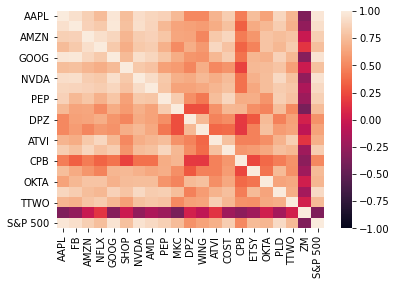

In [24]:
sns.heatmap(correlation, vmin=-1, vmax=1)

In [25]:
AAPLcovariance = combined_daily_returns['AAPL'].cov(combined_daily_returns['S&P 500'])
FBcovariance = combined_daily_returns['FB'].cov(combined_daily_returns['S&P 500'])
AMZNcovariance = combined_daily_returns['AMZN'].cov(combined_daily_returns['S&P 500'])
NFLXcovariance = combined_daily_returns['NFLX'].cov(combined_daily_returns['S&P 500'])
GOOGcovariance = combined_daily_returns['GOOG'].cov(combined_daily_returns['S&P 500'])
SHOPcovariance = combined_daily_returns['SHOP'].cov(combined_daily_returns['S&P 500'])
NVDAcovariance = combined_daily_returns['NVDA'].cov(combined_daily_returns['S&P 500'])
AMDcovariance = combined_daily_returns['AMD'].cov(combined_daily_returns['S&P 500'])
PEPcovariance = combined_daily_returns['PEP'].cov(combined_daily_returns['S&P 500'])
MKCcovariance = combined_daily_returns['MKC'].cov(combined_daily_returns['S&P 500'])
DPZcovariance = combined_daily_returns['DPZ'].cov(combined_daily_returns['S&P 500'])
WINGcovariance = combined_daily_returns['WING'].cov(combined_daily_returns['S&P 500'])
ATVIcovariance = combined_daily_returns['ATVI'].cov(combined_daily_returns['S&P 500'])
COSTcovariance = combined_daily_returns['COST'].cov(combined_daily_returns['S&P 500'])
CPBcovariance = combined_daily_returns['CPB'].cov(combined_daily_returns['S&P 500'])
ETSYcovariance = combined_daily_returns['ETSY'].cov(combined_daily_returns['S&P 500'])
OKTAcovariance = combined_daily_returns['OKTA'].cov(combined_daily_returns['S&P 500'])
PLDcovariance = combined_daily_returns['PLD'].cov(combined_daily_returns['S&P 500'])
TTWOcovariance = combined_daily_returns['TTWO'].cov(combined_daily_returns['S&P 500'])
ZMcovariance = combined_daily_returns['ZM'].cov(combined_daily_returns['S&P 500'])


In [26]:
AAPLvariance = combined_daily_returns['AAPL'].var()
FBvariance = combined_daily_returns['FB'].var()
AMZNvariance = combined_daily_returns['AMZN'].var()
NFLXvariance = combined_daily_returns['NFLX'].var()
GOOGvariance = combined_daily_returns['GOOG'].var()
SHOPvariance = combined_daily_returns['SHOP'].var()
NVDAvariance = combined_daily_returns['NVDA'].var()
AMDvariance = combined_daily_returns['AMD'].var()
PEPvariance = combined_daily_returns['PEP'].var()
MKCvariance = combined_daily_returns['MKC'].var()
DPZvariance = combined_daily_returns['DPZ'].var()
WINGvariance = combined_daily_returns['WING'].var()
ATVIvariance = combined_daily_returns['ATVI'].var()
COSTvariance = combined_daily_returns['COST'].var()
CPBvariance = combined_daily_returns['CPB'].var()
ETSYvariance = combined_daily_returns['ETSY'].var()
OKTAvariance = combined_daily_returns['OKTA'].var()
PLDvariance = combined_daily_returns['PLD'].var()
TTWOvariance = combined_daily_returns['TTWO'].var()
ZMvariance = combined_daily_returns['ZM'].var()


In [27]:
AAPLbeta = AAPLcovariance / AAPLvariance
print(f'Beta of AAPL is {AAPLbeta}')

FBbeta = FBcovariance / FBvariance
print(f'Beta of FB is {FBbeta}')

AMZNbeta = AMZNcovariance / AMZNvariance
print(f'Beta of AMZN is {AMZNbeta}')

NFLXbeta = NFLXcovariance / NFLXvariance
print(f'Beta of NFLX is {NFLXbeta}')

GOOGbeta = GOOGcovariance / GOOGvariance
print(f'Beta of GOOG is {GOOGbeta}')

SHOPbeta = SHOPcovariance / SHOPvariance
print(f'Beta of SHOP is {SHOPbeta}')

NVDAbeta = NVDAcovariance / NVDAvariance
print(f'Beta of NVDA is {NVDAbeta}')

AMDbeta = AMDcovariance / AMDvariance
print(f'Beta of AMD is {AMDbeta}')

PEPbeta = PEPcovariance / PEPvariance
print(f'Beta of PEP is {PEPbeta}')

MKCbeta = MKCcovariance / MKCvariance
print(f'Beta of MKC is {MKCbeta}')

DPZbeta = DPZcovariance / DPZvariance
print(f'Beta of DPZ is {DPZbeta}')

WINGbeta = WINGcovariance / WINGvariance
print(f'Beta of WING is {WINGbeta}')

ATVIbeta = ATVIcovariance / ATVIvariance
print(f'Beta of ATVI is {ATVIbeta}')

COSTbeta =  COSTcovariance / COSTvariance
print(f'Beta of COST is {COSTbeta}')

CPBbeta = CPBcovariance / CPBvariance
print(f'Beta of CPB is {CPBbeta}')

ETSYbeta = ETSYcovariance / ETSYvariance
print(f'Beta of ETSY is {ETSYbeta}')

OKTAbeta = OKTAcovariance / OKTAvariance
print(f'Beta of OKTA is {OKTAbeta}')

PLDbeta = PLDcovariance / PLDvariance
print(f'Beta of PLD is {PLDbeta}')

TTWObeta = TTWOcovariance / TTWOvariance
print(f'Beta of TTWO is {TTWObeta}')

ZMbeta = ZMcovariance / ZMvariance
print(f'Beta of ZM is {ZMbeta}')


Beta of AAPL is 0.8854473279936841
Beta of FB is 0.9152594804938918
Beta of AMZN is 1.2319978605956028
Beta of NFLX is 0.8182866431520169
Beta of GOOG is 1.0405780767706276
Beta of SHOP is 0.5594725918601131
Beta of NVDA is 0.6644493031455987
Beta of AMD is 0.7184562124635974
Beta of PEP is 0.7511441497594239
Beta of MKC is 0.6635899336450992
Beta of DPZ is 0.6574522325110054
Beta of WING is 0.4323933584653676
Beta of ATVI is 0.7648170930697487
Beta of COST is 1.2240144478561297
Beta of CPB is 0.7014860293179744
Beta of ETSY is 0.4604254051837946
Beta of OKTA is 0.6909799724266161
Beta of PLD is 0.7296297269758866
Beta of TTWO is 0.8437490177628885
Beta of ZM is -0.28817275312929447
